In [1]:
import pinocchio as pin
import tsid
import numpy as np
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import os
import matplotlib.pyplot as plt
import gepetto.corbaserver
import time
import commands

import sys
sys.path.append('..')
import plot_utils as plut

## Test Task Space Inverse Dynamics

In [2]:
lxp = 0.1                           # foot length in positive x direction
lxn = 0.11                          # foot length in negative x direction
lyp = 0.069                         # foot length in positive y direction
lyn = 0.069                         # foot length in negative y direction
lz = 0.107                          # foot sole height with respect to ankle joint
mu = 0.3                            # friction coefficient
fMin = 5.0                          # minimum normal force
fMax = 1500.0                       # maximum normal force

rf_frame_name = "leg_right_6_joint"          # right foot joint name
lf_frame_name = "leg_left_6_joint"           # left foot joint name
contactNormal = np.matrix([0., 0., 1.]).T    # direction of the normal to the contact surface

w_com = 1.0                       # weight of center of mass task
w_posture = 0.75                  # weight of joint posture task
w_forceRef = 1e-3                 # weight of force regularization task
w_waist = 1.0                     # weight of waist task

kp_contact = 30.0                 # proportional gain of contact constraint
kp_com = 3000.0                   # proportional gain of center of mass task
kp_posture = 30.0                 # proportional gain of joint posture task
kp_waist = 500.0                  # proportional gain of waist task

dt = 0.001                        # controller time step
PRINT_N = 500                     # print every PRINT_N time steps
DISPLAY_N = 20                    # update robot configuration in viwewer every DISPLAY_N time steps
N_SIMULATION = 4000               # number of time steps simulated

In [3]:
path = "/opt/openrobots/share/talos_data/"
urdf = path + 'urdf/talos_reduced.urdf'
vector = pin.StdVec_StdString()
vector.extend(item for item in path)
robot = tsid.RobotWrapper(urdf, vector, pin.JointModelFreeFlyer(), False)
srdf = path + '/srdf/talos.srdf'

In [4]:
# for gepetto viewer
robot_display = pin.RobotWrapper.BuildFromURDF(urdf, [path, ], pin.JointModelFreeFlyer())
l = commands.getstatusoutput("ps aux |grep 'gepetto-gui'|grep -v 'grep'|wc -l")
if int(l[1]) == 0:
    os.system('gepetto-gui &')
time.sleep(1)
cl = gepetto.corbaserver.Client()
gui = cl.gui
robot_display.initDisplay(loadModel=True)

In [5]:
model = robot.model()
pin.loadReferenceConfigurations(model, srdf, False)
q = model.referenceConfigurations['half_sitting']
v = np.matrix(np.zeros(robot.nv)).T

In [6]:
robot_display.displayCollisions(False)
robot_display.displayVisuals(True)
robot_display.display(q)

In [7]:
assert model.existFrame(rf_frame_name)
assert model.existFrame(lf_frame_name)

In [8]:
t = 0.0 # time
invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
invdyn.computeProblemData(t, q, v)
data = invdyn.data()


In [9]:
# COM
comTask = tsid.TaskComEquality("task-com", robot)
comTask.setKp(kp_com * matlib.ones(3).T)
comTask.setKd(2.0 * np.sqrt(kp_com) * matlib.ones(3).T)
invdyn.addMotionTask(comTask, w_com, 1, 0.0)

True

In [10]:
# WAIST
waistTask = tsid.TaskSE3Equality("keepWaist", robot, 'root_joint')
kp = kp_waist * matlib.ones(6).T
waistTask.setKp(kp)
kd = 2.0 * np.sqrt(kp_waist) * matlib.ones(6).T
waistTask.setKd(kd)
mask = matlib.ones(6).T
mask[:3] = 0.
waistTask.setMask(mask)
invdyn.addMotionTask(waistTask, w_waist, 1, 0.0)

True

In [11]:
# POSTURE
postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture * matlib.ones(robot.nv-6).T)
postureTask.setKd(2.0 * np.sqrt(kp_posture) * matlib.ones(robot.nv-6).T)
mask = matlib.ones(robot.nv-6).T
mask[:11] = 0.
postureTask.mask(mask)
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)


True

In [12]:
# CONTACTS
contact_Point = np.matrix(np.ones((3,4)) * lz)
contact_Point[0, :] = [-lxn, -lxn, lxp, lxp]
contact_Point[1, :] = [-lyn, lyp, -lyn, lyp]

contactRF =tsid.Contact6d("contact_rfoot", robot, rf_frame_name, contact_Point, contactNormal, mu, fMin, fMax)
contactRF.setKp(kp_contact * matlib.ones(6).T)
contactRF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
H_rf_ref = robot.position(data, model.getJointId(rf_frame_name))
contactRF.setReference(H_rf_ref)
invdyn.addRigidContact(contactRF, w_forceRef)

contactLF =tsid.Contact6d("contact_lfoot", robot, lf_frame_name, contact_Point, contactNormal, mu, fMin, fMax)
contactLF.setKp(kp_contact * matlib.ones(6).T)
contactLF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
H_lf_ref = robot.position(data, model.getJointId(lf_frame_name))
contactLF.setReference(H_lf_ref)
invdyn.addRigidContact(contactLF, w_forceRef)

True

In [13]:
# MODEL REFERENCES
com_ref = data.com[0]
trajCom = tsid.TrajectoryEuclidianConstant("traj_com", com_ref)
sampleCom = trajCom.computeNext()

q_ref = q[7:]
trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q_ref)

waist_ref = robot.position(data, model.getJointId('root_joint'))
print waist_ref
trajWaist = tsid.TrajectorySE3Constant("traj_waist", waist_ref)

  R =
1 0 0
0 1 0
0 0 1
  p =       0       0 1.01927



In [14]:
# SOLVER
solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn)

In [15]:
# INITIALIZATION

com_pos = matlib.empty((3, N_SIMULATION))*nan
com_vel = matlib.empty((3, N_SIMULATION))*nan
com_acc = matlib.empty((3, N_SIMULATION))*nan

com_pos_ref = matlib.empty((3, N_SIMULATION))*nan
com_vel_ref = matlib.empty((3, N_SIMULATION))*nan
com_acc_ref = matlib.empty((3, N_SIMULATION))*nan
com_acc_des = matlib.empty((3, N_SIMULATION))*nan # acc_des = acc_ref - Kp*pos_err - Kd*vel_err


In [16]:
# PARAMETERS
offset     = robot.com(data)
amp        = np.matrix([0.0, 0.05, 0.0]).T
two_pi_f             = 2*np.pi*np.matrix([0.0, 0.5, 0.0]).T
two_pi_f_amp         = np.multiply(two_pi_f,amp)
two_pi_f_squared_amp = np.multiply(two_pi_f, two_pi_f_amp)

In [17]:
# SIMULATION LOOP

for i in range(0, N_SIMULATION):
    time_start = time.time()
    
    sampleCom.pos(offset + np.multiply(amp, matlib.sin(two_pi_f*t)))
    sampleCom.vel(np.multiply(two_pi_f_amp, matlib.cos(two_pi_f*t)))
    sampleCom.acc(np.multiply(two_pi_f_squared_amp, -matlib.sin(two_pi_f*t)))
    
    comTask.setReference(sampleCom)
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)

    HQPData = invdyn.computeProblemData(t, q, v)
    # if i == 0: HQPData.print_all()

    sol = solver.solve(HQPData)
    if(sol.status!=0):
        print "QP problem could not be solved! Error code:", sol.status
        break
    
    tau = invdyn.getActuatorForces(sol)
    dv = invdyn.getAccelerations(sol)
    
    com_pos[:,i] = robot.com(invdyn.data())
    com_vel[:,i] = robot.com_vel(invdyn.data())
    com_acc[:,i] = comTask.getAcceleration(dv)
    com_pos_ref[:,i] = sampleCom.pos()
    com_vel_ref[:,i] = sampleCom.vel()
    com_acc_ref[:,i] = sampleCom.acc()
    com_acc_des[:,i] = comTask.getDesiredAcceleration

    if i%PRINT_N == 0:
        print "Time %.3f"%(t)
        if invdyn.checkContact(contactRF.name, sol):
            f = invdyn.getContactForce(contactRF.name, sol)
            print "\tnormal force %s: %.1f"%(contactRF.name.ljust(20,'.'),contactRF.getNormalForce(f))

        if invdyn.checkContact(contactLF.name, sol):
            f = invdyn.getContactForce(contactLF.name, sol)
            print "\tnormal force %s: %.1f"%(contactLF.name.ljust(20,'.'),contactLF.getNormalForce(f))

        print "\ttracking err %s: %.3f"%(comTask.name.ljust(20,'.'),       norm(comTask.position_error, 2))
        print "\t||v||: %.3f\t ||dv||: %.3f"%(norm(v, 2), norm(dv))

    v_mean = v + 0.5*dt*dv
    v += dt*dv
    q = pin.integrate(model, q, dt*v_mean)
    t += dt
    
    if i%DISPLAY_N == 0: robot_display.display(q)

    time_spent = time.time() - time_start
    if(time_spent < dt): time.sleep(dt-time_spent)

Time 0.000
	normal force contact_rfoot.......: 830.0
	normal force contact_lfoot.......: 116.0
	tracking err task-com............: 0.000
	||v||: 0.000	 ||dv||: 10.374
Time 0.500
	normal force contact_rfoot.......: 43.9
	normal force contact_lfoot.......: 841.6
	tracking err task-com............: 0.004
	||v||: 0.060	 ||dv||: 2.323
Time 1.000
	normal force contact_rfoot.......: 424.9
	normal force contact_lfoot.......: 460.9
	tracking err task-com............: 0.001
	||v||: 0.595	 ||dv||: 0.657
Time 1.500
	normal force contact_rfoot.......: 841.1
	normal force contact_lfoot.......: 44.3
	tracking err task-com............: 0.000
	||v||: 0.051	 ||dv||: 1.887
Time 2.000
	normal force contact_rfoot.......: 463.7
	normal force contact_lfoot.......: 422.2
	tracking err task-com............: 0.001
	||v||: 0.581	 ||dv||: 0.653
Time 2.500
	normal force contact_rfoot.......: 45.3
	normal force contact_lfoot.......: 840.0
	tracking err task-com............: 0.001
	||v||: 0.056	 ||dv||: 1.882
Time 3

In [18]:
# PLOT STUFF
time = np.arange(0.0, N_SIMULATION*dt, dt)

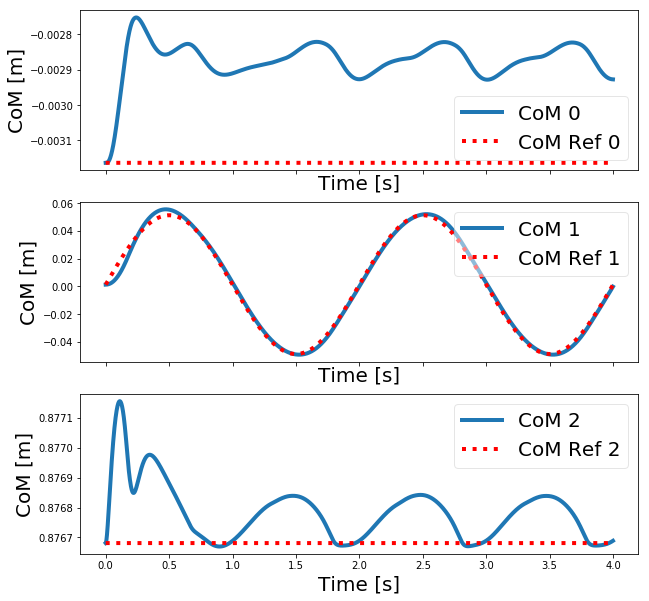

In [19]:
# EVOLUTION OF THE COM POSITION
(f, ax) = plut.create_empty_figure(3, 1, figsize=(10,10))
for i in range(3):
    ax[i].plot(time, com_pos[i,:].A1, label='CoM '+str(i))
    ax[i].plot(time, com_pos_ref[i,:].A1, 'r:', label='CoM Ref '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM [m]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)

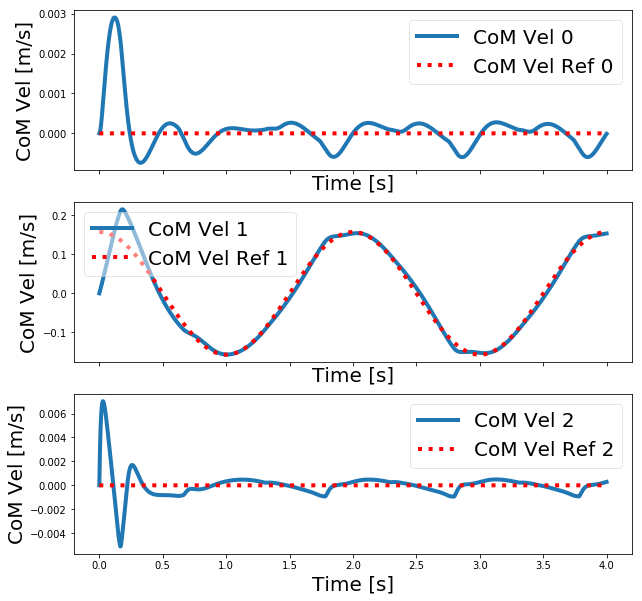

In [20]:
# EVOLUTION OF THE COM VELOCITY
(f, ax) = plut.create_empty_figure(3, 1, figsize=(10,10))
for i in range(3):
    ax[i].plot(time, com_vel[i,:].A1, label='CoM Vel '+str(i))
    ax[i].plot(time, com_vel_ref[i,:].A1, 'r:', label='CoM Vel Ref '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM Vel [m/s]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)

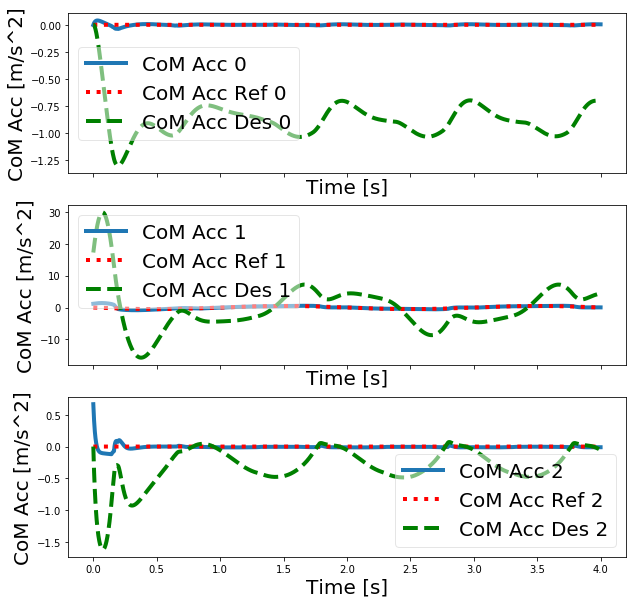

In [21]:
# EVOLUTION OF THE COM ACCELERATION   
(f, ax) = plut.create_empty_figure(3, 1, figsize=(10,10))
for i in range(3):
    ax[i].plot(time, com_acc[i,:].A1, label='CoM Acc '+str(i))
    ax[i].plot(time, com_acc_ref[i,:].A1, 'r:', label='CoM Acc Ref '+str(i))
    ax[i].plot(time, com_acc_des[i,:].A1, 'g--', label='CoM Acc Des '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM Acc [m/s^2]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)
    
plt.show()
